<a href="https://colab.research.google.com/github/saifhmb/MLP_vs_xgboost_fraud_detection/blob/main/XGBoost_fraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and Import Libraries

In [51]:
!pip install huggingface_hub
!pip install transformers
!pip install transformers[torch]
!pip install datasets
!pip install shap
!pip install xgboost
from datasets import load_dataset, load_dataset_builder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report
import shap
import random
# Set Random seeds for reproducibility
np.random.seed(42)
random.seed(42)

## Load the Dataset

In [52]:
dataset_name = "saifhmb/FraudPaymentData"
ds_builder = load_dataset_builder(dataset_name)
ds_builder.info

DatasetInfo(description='', citation='', homepage='', license='', features={'Time_step': Value('string'), 'Transaction_Id': Value('string'), 'Sender_Id': Value('string'), 'Sender_Account': Value('string'), 'Sender_Country': Value('string'), 'Sender_Sector': Value('float64'), 'Sender_lob': Value('string'), 'Bene_Id': Value('string'), 'Bene_Account': Value('string'), 'Bene_Country': Value('string'), 'USD_amount': Value('float64'), 'Label': Value('int64'), 'Transaction_Type': Value('string')}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='fraud_payment_data', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=181672525, num_examples=1048575, shard_lengths=None, dataset_name='fraud_payment_data')}, download_checksums={'hf://datasets/saifhmb/FraudPaymentData@17a6303d393308b90805f433fc3beb1040686660/data/train-00000-of-00001.parquet': {'num_bytes': 44493051, 'checksum': None}}, download_size=44493051, post_processing_si

In [53]:
dataset = load_dataset(dataset_name, split = 'train')

In [54]:
dataset = pd.DataFrame(dataset)
dataset.head()

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,3/15/2022 10:24,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,None,None,None,558.43,0,WITHDRAWAL
1,3/15/2022 10:24,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,3/15/2022 10:24,DEPOSIT-CASH-9833,None,None,None,NaN,None,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,3/15/2022 10:24,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,3/15/2022 10:24,DEPOSIT-CHECK-9806,None,None,None,NaN,None,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK


# EDA

In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1048575 non-null  object 
 1   Transaction_Id    1048575 non-null  object 
 2   Sender_Id         895299 non-null   object 
 3   Sender_Account    895299 non-null   object 
 4   Sender_Country    895299 non-null   object 
 5   Sender_Sector     895299 non-null   float64
 6   Sender_lob        895299 non-null   object 
 7   Bene_Id           897641 non-null   object 
 8   Bene_Account      897641 non-null   object 
 9   Bene_Country      897641 non-null   object 
 10  USD_amount        1048575 non-null  float64
 11  Label             1048575 non-null  int64  
 12  Transaction_Type  1048575 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 104.0+ MB


In [56]:
print(f"Dataset shape before dropping NaNs: {dataset.shape}")
dataset.dropna(inplace=True)
print(f"Dataset shape after dropping NaNs: {dataset.shape}")
dataset.info()

Dataset shape before dropping NaNs: (1048575, 13)
Dataset shape after dropping NaNs: (744365, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 744365 entries, 1 to 1048574
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Time_step         744365 non-null  object 
 1   Transaction_Id    744365 non-null  object 
 2   Sender_Id         744365 non-null  object 
 3   Sender_Account    744365 non-null  object 
 4   Sender_Country    744365 non-null  object 
 5   Sender_Sector     744365 non-null  float64
 6   Sender_lob        744365 non-null  object 
 7   Bene_Id           744365 non-null  object 
 8   Bene_Account      744365 non-null  object 
 9   Bene_Country      744365 non-null  object 
 10  USD_amount        744365 non-null  float64
 11  Label             744365 non-null  int64  
 12  Transaction_Type  744365 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 79.5+ MB


In [57]:
dataset['Time_step'].describe()

,Time_step
count,744365
unique,382275
top,11/20/2034 16:35
freq,73


In [58]:
dataset['Time_step'] = pd.to_datetime(dataset['Time_step'])

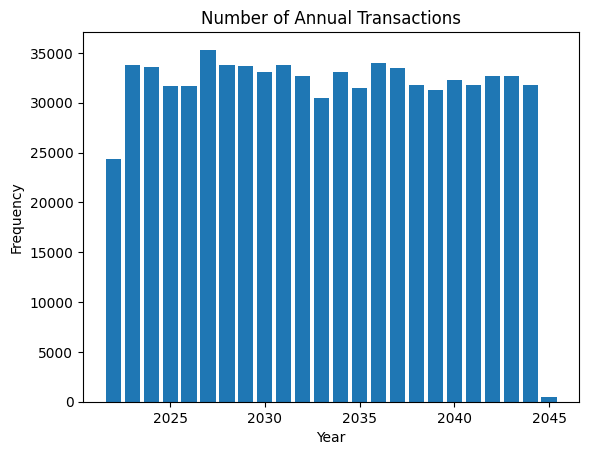

In [59]:
year_counts = dataset['Time_step'].dt.year.value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Annual Transactions')
plt.show()

In [60]:
dataset['Transaction_Id'].describe()

,Transaction_Id
count,744365
unique,744365
top,PAY-CHECK-1536827
freq,1


In [61]:
# All the values of Transaction_Id are unique. Therefore, it is a high cardinality feature

In [62]:
dataset['Sender_Id'].describe()

,Sender_Id
count,744365
unique,40957
top,JPMC-CLIENT-303611
freq,132


In [63]:
dataset['Sender_Account'].describe()

,Sender_Account
count,744365
unique,51917
top,ACCOUNT-1175973
freq,74


In [64]:
dataset['Sender_Country'].describe()

,Sender_Country
count,744365
unique,252
top,USA
freq,564266


In [65]:
dataset['Sender_Sector'].describe()

,Sender_Sector
count,744365.000000
mean,25024.607663
std,14429.958803
min,0.000000
25%,12551.000000
50%,25026.000000
75%,37532.000000
max,49999.000000


In [66]:
dataset['Sender_lob'].describe()

,Sender_lob
count,744365
unique,1
top,CCB
freq,744365


In [67]:
# Sender_lob has a single unique value so this can be DROPPED

In [68]:
dataset['Bene_Id'].describe()

,Bene_Id
count,744365
unique,194651
top,CLIENT-1029620
freq,61


In [69]:
dataset['Bene_Account'].describe()

,Bene_Account
count,744365
unique,205268
top,ACCOUNT-1029621
freq,61


In [70]:
dataset['Bene_Country'].describe()

,Bene_Country
count,744365
unique,252
top,USA
freq,395722


In [71]:
dataset['USD_amount'].describe()

,USD_amount
count,744365.000000
mean,510.397698
std,543.078385
min,0.000000
25%,100.700000
50%,400.450000
75%,723.130000
max,19927.990000


In [72]:
dataset['Label'].value_counts()

,count
Label,
0,728983
1,15382


## 0 is non-fraudulent and 1 is fraudulent

In [73]:
dataset['Transaction_Type'].describe()

,Transaction_Type
count,744365
unique,4
top,MAKE-PAYMENT
freq,390511


In [74]:
dataset = dataset.drop(['Transaction_Id', 'Sender_lob', 'Sender_Sector', 'Sender_Id', 'Bene_Id'], axis = 1) #  deleting features with high cardinality and no variance
dataset.head(1)

,Time_step,Sender_Account,Sender_Country,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
1,2022-03-15 10:24:00,ACCOUNT-10109,USA,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT


# Feature Engineering
## Convert Time_step to Month, Weekday, Hour, and AM/PM

In [75]:
dataset['Month'] = dataset['Time_step'].dt.month

In [76]:
dataset['Weekday'] = dataset['Time_step'].dt.strftime('%a')

In [77]:
dataset['Hour'] = dataset['Time_step'].dt.hour

In [78]:
dataset['AMorPM'] = np.where(dataset['Hour'] <12, 'AM', 'PM')

In [79]:
dataset = dataset.drop(['Time_step'], axis = 1)

In [80]:
dataset.head(1)

,Sender_Account,Sender_Country,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Month,Weekday,Hour,AMorPM
1,ACCOUNT-10109,USA,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,3,Tue,10,AM


In [81]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744365 entries, 1 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sender_Account    744365 non-null  object 
 1   Sender_Country    744365 non-null  object 
 2   Bene_Account      744365 non-null  object 
 3   Bene_Country      744365 non-null  object 
 4   USD_amount        744365 non-null  float64
 5   Label             744365 non-null  int64  
 6   Transaction_Type  744365 non-null  object 
 7   Month             744365 non-null  int32  
 8   Weekday           744365 non-null  object 
 9   Hour              744365 non-null  int32  
 10  AMorPM            744365 non-null  object 
dtypes: float64(1), int32(2), int64(1), object(7)
memory usage: 62.5+ MB


## Encoding Categorical data and Feature Scaling

### Encoding the Independent Variables and Applying Feature Scaling

In [82]:
dataset.select_dtypes(include=np.number).head(1)

,USD_amount,Label,Month,Hour
1,622.78,0,3,10


In [83]:
categoricalColumns = ['Sender_Account', 'Sender_Country',  'Bene_Account', 'Bene_Country', 'Transaction_Type',
                      'Month', 'Weekday', 'Hour', 'AMorPM']

In [84]:
for category in categoricalColumns:
  dataset[category] = dataset[category].astype('category')

In [85]:
dataset['USD_amount'] = dataset['USD_amount'].astype('float32')

In [86]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744365 entries, 1 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Sender_Account    744365 non-null  category
 1   Sender_Country    744365 non-null  category
 2   Bene_Account      744365 non-null  category
 3   Bene_Country      744365 non-null  category
 4   USD_amount        744365 non-null  float32 
 5   Label             744365 non-null  int64   
 6   Transaction_Type  744365 non-null  category
 7   Month             744365 non-null  category
 8   Weekday           744365 non-null  category
 9   Hour              744365 non-null  category
 10  AMorPM            744365 non-null  category
dtypes: category(9), float32(1), int64(1)
memory usage: 38.3 MB


In [87]:
onehot_categorical = OneHotEncoder(handle_unknown='ignore', sparse_output= False)
categorical_transformer = Pipeline(steps = [('onehot', onehot_categorical)])
sc = StandardScaler()
numerical_transformer = Pipeline(steps = [('scale', sc)])


In [88]:
numericalColumns = ['USD_amount']

In [89]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns)], remainder ='passthrough')
preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),('num',numerical_transformer,numericalColumns)],
                                            remainder="passthrough")

In [90]:
y = dataset.iloc[:, 5].values

In [91]:
dataset = dataset.drop(['Label'], axis = 1)

In [92]:
X = dataset

## Splitting the dataset into the Training set and Test set

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [94]:
len(y_test)

148873

## Handling Imbalanced Dataset

In [95]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [96]:
under_sampler = RandomUnderSampler()
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print(pd.Series(y_train).value_counts())

0    12273
1    12273
Name: count, dtype: int64


## Train the model

In [97]:
from sklearn.model_selection import GridSearchCV
import numpy as np
param_grid = {'classifier__n_estimators': [5000],
              'classifier__learning_rate': [0.3]
}

In [98]:
classifier = XGBClassifier(objective = 'binary:logistic')

In [99]:
model = Pipeline(steps = [('preprocessorAll', preprocessorForAllColumns),('classifier', classifier)])

In [ ]:
grid_search = GridSearchCV(estimator = model, param_grid=param_grid, scoring ='accuracy')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

In [ ]:
#model.fit(X_train, y_train)

## Predicting the Test set results

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
#y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc = accuracy_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
print(f'Model accuracy is {round(acc, 2)}')
print(f'Model Precision is {round(ps, 2)}')
print(f'Model Recall is {round(rs, 2)}')

## Making the Confusion Matrix and evaluating performance

In [ ]:
'''cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['0 - Normal', '1 - Fraudulent']))
disp.plot()
plt.show()
acc = accuracy_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
print(f'Model accuracy is {round(acc, 2)}')
print(f'Model Precision is {round(ps, 2)}')
print(f'Model Recall is {round(rs, 2)}')
'''

## Model explainability using SHAP